# Import

In [ ]:
import zipfile
import os
from collections import Counter
import matplotlib.pyplot as plt
import random
import numpy as np
from collections import Counter
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Reading Data

In [ ]:
zip_path = "/content/Teeth_Dataset.zip"
extract_path = "/content/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(os.listdir("/content/"))

['.config', 'Teeth_Dataset.zip', 'Teeth_Dataset', 'sample_data']


# Exploring Data

In [ ]:
data_dir = "/content/Teeth_Dataset"

for split in ["Training", "Validation", "Testing"]:
    split_path = os.path.join(data_dir, split)
    print(f"\n{split.upper()} SET:")
    print(os.listdir(split_path))



TRAINING SET:
['CaS', 'OC', 'Gum', 'OT', 'MC', 'OLP', 'CoS']

VALIDATION SET:
['CaS', 'OC', 'Gum', 'OT', 'MC', 'OLP', 'CoS']

TESTING SET:
['CaS', 'OC', 'Gum', 'OT', 'MC', 'OLP', 'CoS']


In [ ]:
def count_images(split_path):
    counts = {}
    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        if os.path.isdir(cls_path):
            counts[cls] = len(os.listdir(cls_path))
    return counts

for split in ["Training", "Validation", "Testing"]:
    split_path = os.path.join(data_dir, split)
    counts = count_images(split_path)
    print(f"\n{split.upper()} counts:")
    print(counts)



TRAINING counts:
{'CaS': 480, 'OC': 324, 'Gum': 360, 'OT': 393, 'MC': 540, 'OLP': 540, 'CoS': 450}

VALIDATION counts:
{'CaS': 160, 'OC': 108, 'Gum': 120, 'OT': 131, 'MC': 180, 'OLP': 180, 'CoS': 149}

TESTING counts:
{'CaS': 160, 'OC': 108, 'Gum': 120, 'OT': 131, 'MC': 180, 'OLP': 180, 'CoS': 149}


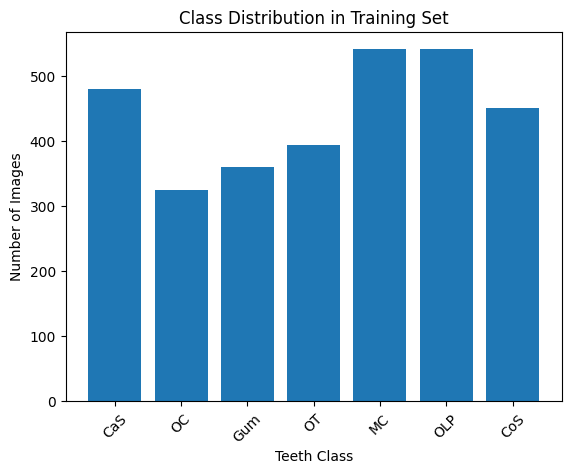

In [ ]:
train_counts = count_images(os.path.join(data_dir, "Training"))

plt.bar(train_counts.keys(), train_counts.values())
plt.title("Class Distribution in Training Set")
plt.xlabel("Teeth Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()


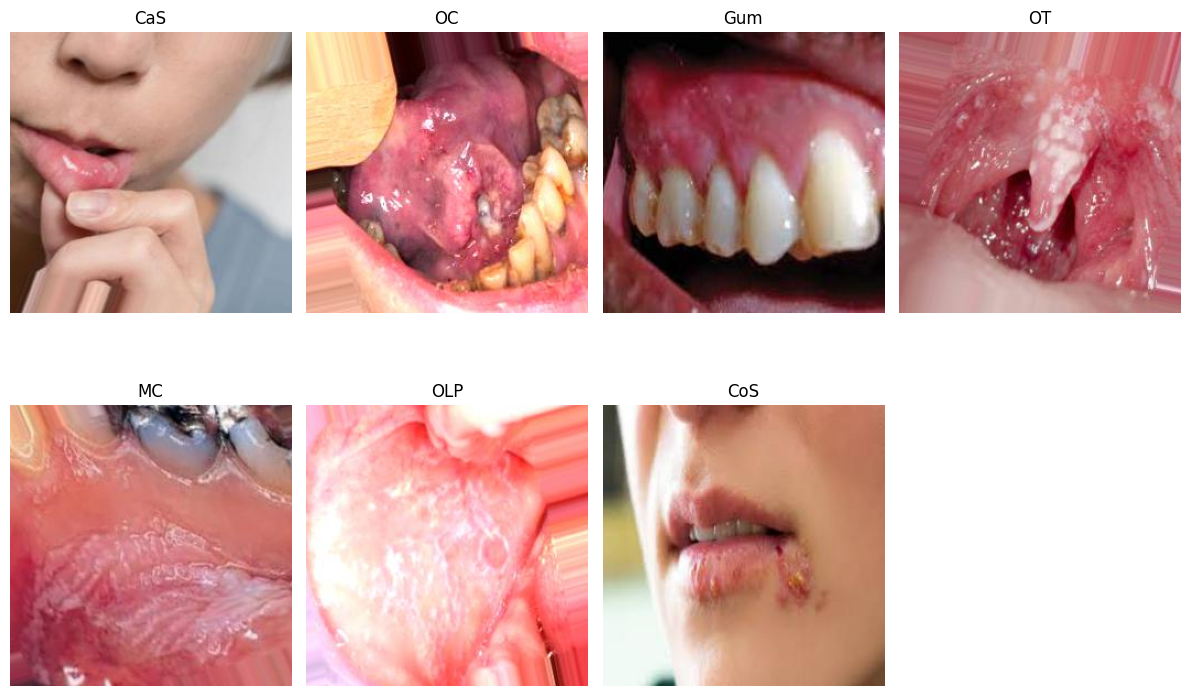

In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

train_path = os.path.join(data_dir, "Training")

classes = os.listdir(train_path)

plt.figure(figsize=(12, 8))
for i, cls in enumerate(classes[:7]):  # limit to 7 classes
    cls_folder = os.path.join(train_path, cls)
    img_file = random.choice(os.listdir(cls_folder))
    img_path = os.path.join(cls_folder, img_file)

    img = mpimg.imread(img_path)
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.tight_layout()
plt.show()


# Preprocessing

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=30,
    brightness_range=[0.8, 1.2],
    zoom_range=0.2,
    shear_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    directory="/content/Teeth_Dataset/Training",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    directory="/content/Teeth_Dataset/Validation",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=False,
    classes=list(train_gen.class_indices.keys())
)


print("Detected mapping:", train_gen.class_indices)
idx_to_class = {v: k for k, v in train_gen.class_indices.items()}
print("idx_to_class:", idx_to_class)


Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Detected mapping: {'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}
idx_to_class: {0: 'CaS', 1: 'CoS', 2: 'Gum', 3: 'MC', 4: 'OC', 5: 'OLP', 6: 'OT'}


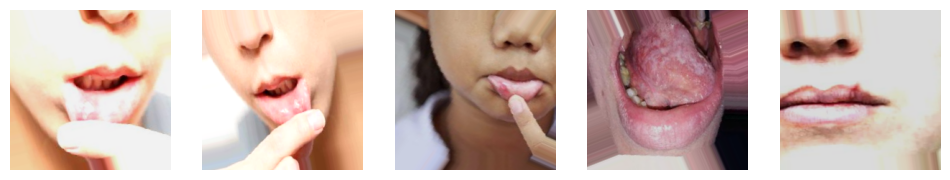

In [ ]:
images, labels = next(train_gen)
plt.figure(figsize=(12,6))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(images[i])
    plt.axis("off")
plt.show()


# VGG 16 Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, initializers, regularizers

wd = 1e-4  # weight decay (L2)

def conv_bn_relu(x, out_c, k=3, p="same"):
    x = layers.Conv2D(
        out_c, k, padding=p, use_bias=False,
        kernel_initializer=initializers.HeNormal(),
        kernel_regularizer=regularizers.l2(wd)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def VGG16(num_classes=7, block_dropout=0.15, head_dropout=0.3):
    inputs = layers.Input(shape=(224, 224, 3))

    # Block 1
    x = conv_bn_relu(inputs, 16)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Dropout(block_dropout)(x)

    # Block 2
    x = conv_bn_relu(x, 32)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Dropout(block_dropout)(x)

    # Block 3
    x = conv_bn_relu(x, 64)
    x = conv_bn_relu(x, 64)
    x = conv_bn_relu(x, 64)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Dropout(block_dropout)(x)

    # Block 4
    x = conv_bn_relu(x, 128)
    x = conv_bn_relu(x, 128)
    x = conv_bn_relu(x, 128)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Dropout(block_dropout)(x)
    # Block 5
    x = conv_bn_relu(x, 128)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Dropout(block_dropout)(x)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(
        512, activation="relu",
        kernel_initializer=initializers.HeNormal(),
        kernel_regularizer=regularizers.l2(wd)
    )(x)
    x = layers.Dropout(head_dropout)(x)

    outputs = layers.Dense(
        num_classes, activation="softmax",
        kernel_initializer=initializers.GlorotUniform(),
        kernel_regularizer=regularizers.l2(wd)
    )(x)

    return models.Model(inputs, outputs, name="VGG16_Custom")

model = VGG16(num_classes=7)

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()


Model: "VGG16_Custom"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 224, 224, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 685,943 (2.62 MB)

 Trainable params: 684,439 (2.61 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=70,

)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 75s 599ms/step - accuracy: 0.2463 - loss: 2.2890 - val_accuracy: 0.1449 - val_loss: 4.5265
Epoch 2/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 436ms/step - accuracy: 0.3377 - loss: 1.9369 - val_accuracy: 0.1615 - val_loss: 6.2441
Epoch 3/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 44s 451ms/step - accuracy: 0.3912 - loss: 1.8139 - val_accuracy: 0.2140 - val_loss: 3.1721
Epoch 4/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 431ms/step - accuracy: 0.4007 - loss: 1.7425 - val_accuracy: 0.2519 - val_loss: 2.7366
Epoch 5/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 43s 440ms/step - accuracy: 0.4587 - loss: 1.6077 - val_accuracy: 0.3949 - val_loss: 1.9426
Epoch 6/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 43s 445ms/step - accuracy: 0.4819 - loss: 1.5516 - val_accuracy: 0.4504 - val_loss: 1.7003
Epoch 7/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 43s 438ms/step - accuracy: 0.5242 - loss: 1.4623 - val_accuracy: 0.4027 - val_loss: 1.8511
Epoch 8/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 430ms/step - accuracy: 0.5522 - loss: 1.4023 - val_accu

In [ ]:
model.save("teeth_classificationfinal.h5")

In [ ]:
model.save_weights("teeth_classifier_final.weights.h5")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    directory="/content/Teeth_Dataset/Testing",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=False,
    classes=list(train_gen.class_indices.keys())
)

print("Test mapping:", test_gen.class_indices)


Found 1028 images belonging to 7 classes.
Test mapping: {'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}


In [ ]:
test_loss, test_acc = model.evaluate(test_gen, verbose=0)
print(f"Test: loss={test_loss:.4f}  acc={test_acc:.4f}")


Test: loss=0.5852  acc=0.8920


In [ ]:
import matplotlib.pyplot as plt

def plot_acc_loss(acc, val_acc, loss, val_loss, epochs):
    epochs_range = range(1, len(epochs)+1)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'r-', label='Training Accuracy')
    plt.plot(epochs_range, val_acc, 'g-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'r-', label='Training Loss')
    plt.plot(epochs_range, val_loss, 'g-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


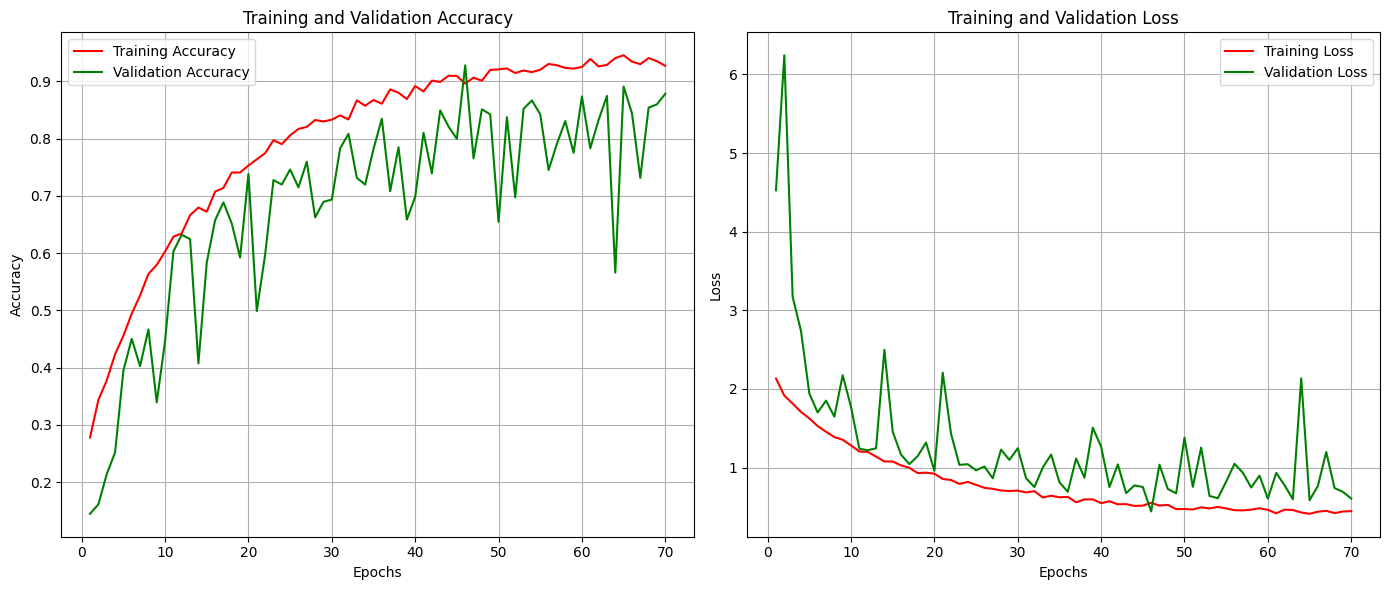

In [ ]:
model_history = history.history

acc = model_history['accuracy']
val_acc = model_history['val_accuracy']
loss = model_history['loss']
val_loss = model_history['val_loss']
epochs = history.epoch

plot_acc_loss(acc, val_acc, loss, val_loss, epochs)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_conf_matrix(model, test_generator, class_names):
    y_true = test_generator.classes

    y_pred_probs = model.predict(test_generator)

    y_pred = np.argmax(y_pred_probs, axis=1)

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step


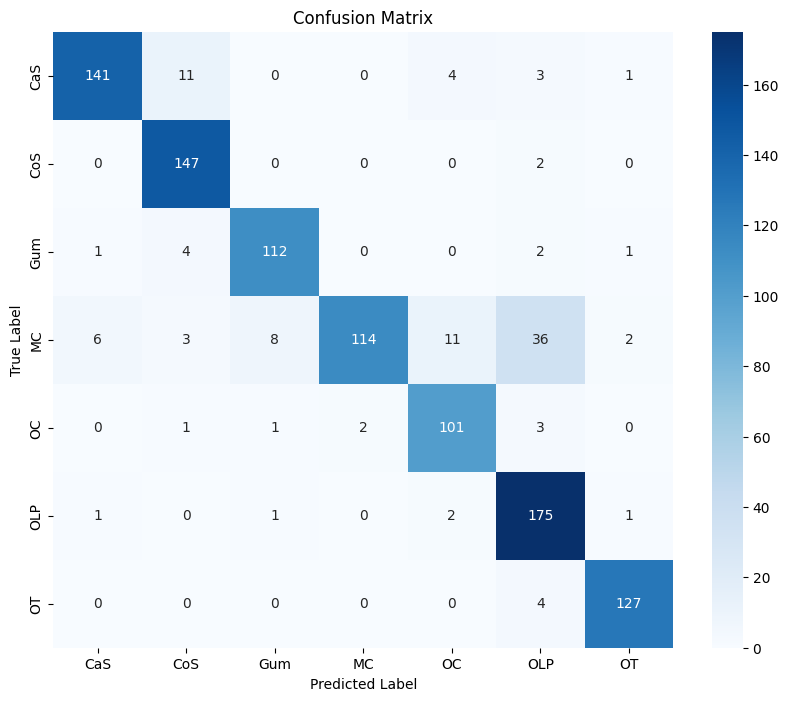

In [ ]:
class_names = list(test_gen.class_indices.keys())

plot_conf_matrix(model, test_gen, class_names)

# Pretrained Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import resnet50

In [ ]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow as tf

In [ ]:
pretrain_model=tf.keras.applications.resnet50.ResNet50(weights='imagenet',
                                              include_top=False,
                                              input_shape=(224,224,3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
IMG_SIZE   = 224
BATCH_SIZE = 32
SEED       = 42

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    rotation_range=30,
    brightness_range=[0.8, 1.2],
    zoom_range=0.2,
    shear_range=0.2
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(
    "/content/Teeth_Dataset/Training",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=True,
    seed=SEED
)
val_gen = val_datagen.flow_from_directory(
    "/content/Teeth_Dataset/Validation",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=False,
    classes=list(train_gen.class_indices.keys())
)


Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


In [ ]:
for layer in pretrain_model.layers:
    layer.trainable=True

In [ ]:
input=tf.keras.layers.Input(shape=(224,224,3))
x=pretrain_model(input,training=True)
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dropout(0.4)(x)
output=tf.keras.layers.Dense(7,activation='softmax')(x)
model_2=tf.keras.Model(input,output)

In [ ]:
model_2.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │        14,343 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,602,055 (90.03 MB)

 Trainable params: 23,548,935 (89.83 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
model_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history=model_2.fit(train_gen,
                    validation_data=val_gen,
                    epochs=50)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 151s 892ms/step - accuracy: 0.3846 - loss: 1.9017 - val_accuracy: 0.1255 - val_loss: 32.5993
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 58s 594ms/step - accuracy: 0.6178 - loss: 1.0460 - val_accuracy: 0.4018 - val_loss: 3.4726
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 56s 579ms/step - accuracy: 0.7583 - loss: 0.7208 - val_accuracy: 0.3482 - val_loss: 2.9996
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 83s 589ms/step - accuracy: 0.7994 - loss: 0.5622 - val_accuracy: 0.4591 - val_loss: 2.3585
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 58s 595ms/step - accuracy: 0.8316 - loss: 0.4865 - val_accuracy: 0.4591 - val_loss: 3.7895
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 57s 587ms/step - accuracy: 0.8823 - loss: 0.3722 - val_accuracy: 0.6216 - val_loss: 1.8197
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 56s 574ms/step - accuracy: 0.8893 - loss: 0.3250 - val_accuracy: 0.6663 - val_loss: 1.3841
Epoch 8/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 55s 571ms/step - accuracy: 0.9104 - loss: 0.2573 - val_ac

In [ ]:
model_2.save("teeth_classification_pretrained.h5")

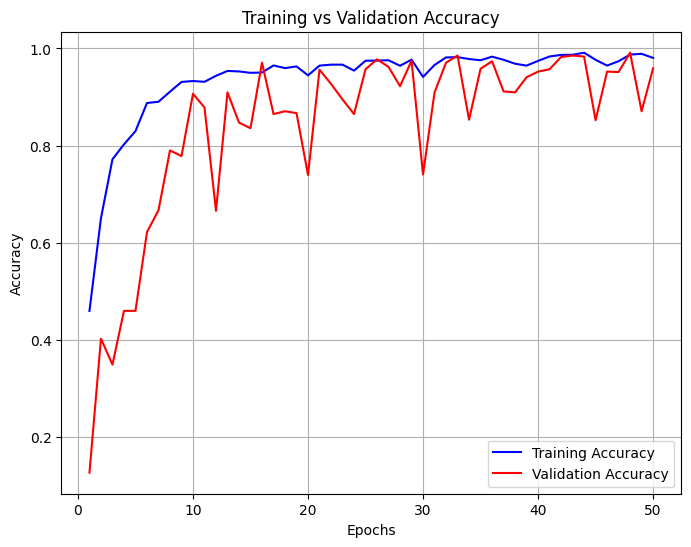

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


**the validation accuracy needs to be more smoother so i will make the learning rate smaller and i will change the augmentation and see the difference.**

In [ ]:
pretrain_model_2=tf.keras.applications.resnet50.ResNet50(weights='imagenet',
                                              include_top=False,
                                              input_shape=(224,224,3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
IMG_SIZE   = 224
BATCH_SIZE = 32
SEED       = 42

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.15,
    shear_range=0.1,
    brightness_range=[0.9, 1.1]
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(
    "/content/Teeth_Dataset/Training",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=True,
    seed=SEED
)

val_gen = val_datagen.flow_from_directory(
    "/content/Teeth_Dataset/Validation",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=False,
    classes=list(train_gen.class_indices.keys())
)

num_classes = train_gen.num_classes


Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


In [ ]:
for layer in pretrain_model_2.layers:
    layer.trainable=True

In [ ]:
input=tf.keras.layers.Input(shape=(224,224,3))
x=pretrain_model_2(input,training=False)
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dropout(0.4)(x)
output=tf.keras.layers.Dense(7,activation='softmax')(x)
model_3=tf.keras.Model(input,output)

In [ ]:
model_3.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │        14,343 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,602,055 (90.03 MB)

 Trainable params: 23,548,935 (89.83 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
opt = keras.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-4, clipnorm=1.0)
model_3.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:

history=model_3.fit(train_gen,
                    validation_data=val_gen,
                    epochs=15)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 168s 968ms/step - accuracy: 0.2321 - loss: 2.0792 - val_accuracy: 0.4854 - val_loss: 1.3583
Epoch 2/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 52s 532ms/step - accuracy: 0.5018 - loss: 1.3483 - val_accuracy: 0.7529 - val_loss: 0.7868
Epoch 3/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 54s 560ms/step - accuracy: 0.7165 - loss: 0.8543 - val_accuracy: 0.8706 - val_loss: 0.4691
Epoch 4/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 79s 534ms/step - accuracy: 0.7880 - loss: 0.6297 - val_accuracy: 0.9173 - val_loss: 0.2950
Epoch 5/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 52s 536ms/step - accuracy: 0.8739 - loss: 0.4078 - val_accuracy: 0.9426 - val_loss: 0.1883
Epoch 6/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 84s 558ms/step - accuracy: 0.9203 - loss: 0.2687 - val_accuracy: 0.9718 - val_loss: 0.1118
Epoch 7/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 52s 535ms/step - accuracy: 0.9523 - loss: 0.1792 - val_accuracy: 0.9825 - val_loss: 0.0687
Epoch 8/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 52s 532ms/step - accuracy: 0.9715 - loss: 0.1196 - val_acc

In [ ]:
model_3.save("teeth_classification_pretrained_finall.h5")

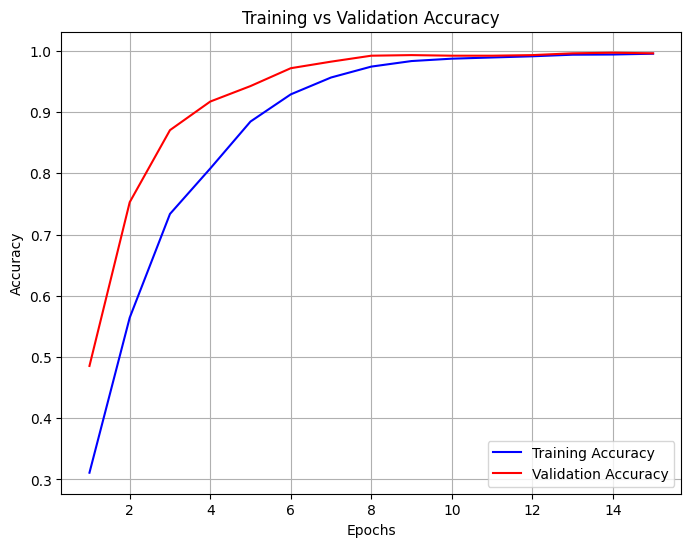

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


**The accuracy become smoother**

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_gen = test_datagen.flow_from_directory(
    "/content/Teeth_Dataset/Testing",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=False,
    classes=list(train_gen.class_indices.keys())
)

test_loss, test_acc = model_3.evaluate(test_gen, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Found 1028 images belonging to 7 classes.
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9958 - loss: 0.0092

Test Loss: 0.0131
Test Accuracy: 0.9951


# deployment

In [7]:
!pip -q install streamlit pillow
!pip -q install streamlit cloudflared

In [16]:
%%writefile app.py
import os, io, json
import numpy as np
from PIL import Image
import streamlit as st
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input

MODEL_PATH = "/content/teeth_classification_pretrained_finall.h5"
CLASS_IDX_PATH = "/content/class_indices.json"
IMG_SIZE = (224, 224)

with open(CLASS_IDX_PATH) as f:
    class_indices = json.load(f)
CLASS_NAMES = [None] * len(class_indices)
for name, i in class_indices.items():
    CLASS_NAMES[i] = name

@st.cache_resource
def load_model():
    return tf.keras.models.load_model(MODEL_PATH)

model = load_model()

def preprocess_image(pil_img: Image.Image) -> np.ndarray:
    pil_img = pil_img.convert("RGB").resize(IMG_SIZE)
    x = np.array(pil_img).astype("float32")
    x = preprocess_input(x)
    return np.expand_dims(x, 0)

def predict(pil_img: Image.Image):
    x = preprocess_image(pil_img)
    preds = model.predict(x)
    probs = tf.nn.softmax(preds[0]).numpy()
    top_idx = int(np.argmax(probs))
    top_conf = float(probs[top_idx])
    return top_idx, top_conf

st.set_page_config(page_title="Teeth Disease Classifier", layout="centered")
st.title("Teeth Disease Classification")

file = st.file_uploader("Upload tooth image", type=["jpg","jpeg","png"])
if file:
    pil = Image.open(io.BytesIO(file.read()))
    st.image(pil, use_container_width=True)

    with st.spinner("Predicting..."):
        idx, conf = predict(pil)

    label = CLASS_NAMES[idx] if 0 <= idx < len(CLASS_NAMES) else f"class_{idx}"
    st.success(f"Prediction: {label}")


Overwriting app.py


In [17]:
!pkill -f "streamlit run" || true
!streamlit run /content/app.py --server.port 8501 --server.headless true &>/content/streamlit.log &
!sleep 3
!tail -n 30 /content/streamlit.log


^C



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.148.218.72:8501



In [18]:
!curl -L -o /usr/local/bin/cloudflared \
  https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x /usr/local/bin/cloudflared
!cloudflared --version


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 39.2M  100 39.2M    0     0  95.5M      0 --:--:-- --:--:-- --:--:-- 95.5M
cloudflared version 2025.8.1 (built 2025-08-21-1535 UTC)


In [19]:
!cloudflared tunnel --url http://localhost:8501 --no-autoupdate


2025-09-11T21:44:51Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2025-09-11T21:44:51Z INF Requesting new quick Tunnel on trycloudflare.com...
2025-09-11T21:44:55Z INF +--------------------------------------------------------------------------------------------+
2025-09-11T21:44:55Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachable):  |
2025-09-11T21:44:55Z INF |  https://suffer-brussels-ron-installations.trycloudfla